In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import sys

from fredapi import Fred

sys.path.append('../economic_data_analysis_with_pandas')
from settings import FRED_API_KEY as fred_key

# Setup

In [2]:

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]


# Interact with Fred

In [3]:

# Create the Fred object
fred = Fred(api_key=fred_key)

# General search for economic data on Fred to get a feeling for the content
fred.search('S&P')

id realtime_start realtime_end  \
series id                                                        
CSUSHPINSA              CSUSHPINSA     2025-03-04   2025-03-04   
CSUSHPISA                CSUSHPISA     2025-03-04   2025-03-04   
SP500                        SP500     2025-03-04   2025-03-04   
SPCS20RSA                SPCS20RSA     2025-03-04   2025-03-04   
SPCS20RNSA              SPCS20RNSA     2025-03-04   2025-03-04   
...                            ...            ...          ...   
EMVIPMAT                  EMVIPMAT     2025-03-04   2025-03-04   
HC01ESTVC1612065  HC01ESTVC1612065     2025-03-04   2025-03-04   
HC01ESTVC1628149  HC01ESTVC1628149     2025-03-04   2025-03-04   
HC01ESTVC1640133  HC01ESTVC1640133     2025-03-04   2025-03-04   
HC01ESTVC1636037  HC01ESTVC1636037     2025-03-04   2025-03-04   

                                                              title  \
series id                                                             
CSUSHPINSA        S&P CoreLogic Case-Shiller U.S. National Home ...   
CSUSHPISA         S&P CoreLogic Case-Shiller U.S. National Home ...   
SP500                                                       S&P 500   
SPCS20RSA         S&P CoreLogic Case-Shiller 20-City Composite H...   
SPCS20RNSA        S&P CoreLogic Case-Shiller 20-City Composite H...   
...                                                             ...   
EMVIPMAT          Equity Market Volatility Tracker: Intellectual...   
HC01ESTVC1612065  High School Graduate or Higher (5-year estimat...   
HC01ESTVC1628149  High School Graduate or Higher (5-year estimat...   
HC01ESTVC1640133  High School Graduate or Higher (5-year estimat...   
HC01ESTVC1636037  High School Graduate or Higher (5-year estimat...   

                 observation_start observation_end     frequency  \
series id                                                          
CSUSHPINSA              1987-01-01      2024-12-01       Monthly   
CSUSHPISA               1987-01-01      2024-12-01       Monthly   
SP500                   2015-03-05      2025-03-04  Daily, Close   
SPCS20RSA               2000-01-01      2024-12-01       Monthly   
SPCS20RNSA              2000-01-01      2024-12-01       Monthly   
...                            ...             ...           ...   
EMVIPMAT                1985-01-01      2025-01-01       Monthly   
HC01ESTVC1612065        2010-01-01      2023-01-01        Annual   
HC01ESTVC1628149        2010-01-01      2023-01-01        Annual   
HC01ESTVC1640133        2010-01-01      2023-01-01        Annual   
HC01ESTVC1636037        2010-01-01      2023-01-01        Annual   

                 frequency_short               units         units_short  \
series id                                                                  
CSUSHPINSA                     M  Index Jan 2000=100  Index Jan 2000=100   
CSUSHPISA                      M  Index Jan 2000=100  Index Jan 2000=100   
SP500                          D               Index               Index   
SPCS20RSA                      M  Index Jan 2000=100  Index Jan 2000=100   
SPCS20RNSA                     M  Index Jan 2000=100  Index Jan 2000=100   
...                          ...                 ...                 ...   
EMVIPMAT                       M               Index               Index   
HC01ESTVC1612065               A             Percent                   %   
HC01ESTVC1628149               A             Percent                   %   
HC01ESTVC1640133               A             Percent                   %   
HC01ESTVC1636037               A             Percent                   %   

                      seasonal_adjustment seasonal_adjustment_short  \
series id                                                             
CSUSHPINSA        Not Seasonally Adjusted                       NSA   
CSUSHPISA             Seasonally Adjusted                        SA   
SP500             Not Seasonally Adjusted                       NSA   
SPCS20RSA           

<Axes: title={'center': 'S&P 500'}>

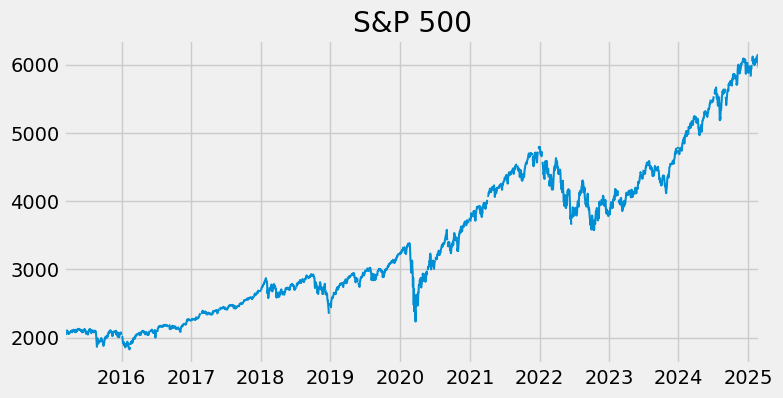

In [4]:

# Pull raw data
sp500 = fred.get_series(series_id='SP500')

# eda
sp500.plot(figsize=(8,4), title='S&P 500', lw=1.5)


# Pull and Join Multiple Time Series

## Unemployment Rate

In [5]:
unemp_df_raw = fred.search('unemployment state rate', filter=('frequency', 'Monthly'), order_by='popularity', limit=2000)
unemp_df = unemp_df_raw.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]
unemp_df = unemp_df.loc[unemp_df['id'].str.endswith('UR')]
unemp_df = unemp_df.loc[unemp_df['id'].str.len() == 4]
unemp_id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()

In [6]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

unemp_results = pd.concat(all_results, axis=1).drop(['PRUR'], axis=1)
unemp_results.columns = [unemp_id_to_state[c] for c in unemp_results.columns]
unemp_results.rename(columns={'the District of Columbia':'DC'}, inplace=True)

# null-check
# unemp_results.isna().sum(axis=1).plot()

In [7]:
# Plot States unemployment rate
px.line(unemp_results)

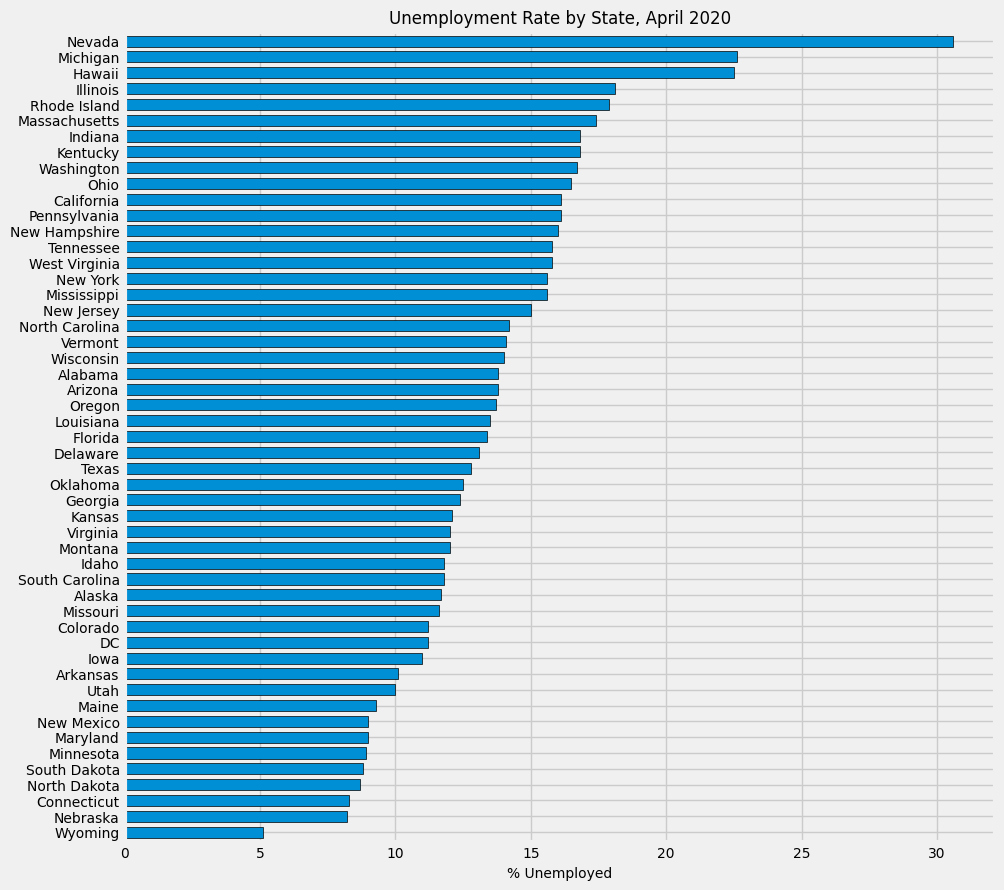

In [8]:
ax = unemp_results.loc[unemp_results.index == '2020-04-01'].T \
        .sort_values('2020-04-01') \
        .plot(kind='barh',
              figsize=(10,10),
              edgecolor = 'black',
              width = 0.7)
ax.legend().remove()
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.title('Unemployment Rate by State, April 2020', fontsize=12)
ax.set_xlabel('% Unemployed', fontsize=10)
plt.show()

## Participation Rate

In [9]:
part_df_raw = fred.search('participation state rate', filter=('frequency', 'Monthly'), order_by='popularity', limit=2000)
part_df = part_df_raw.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df.loc[part_df['title'].str.contains('Labor Force Participation Rate for ')]
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()

In [10]:
all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

part_results = pd.concat(all_results, axis=1)
part_results.columns = [part_id_to_state[c] for c in part_results.columns]
part_results.rename(columns={'District Of Columbia':'DC'}, inplace=True)

# null-check
# unemp_results.isna().sum(axis=1).plot()

In [11]:
# Plot States Labor Force Participation Rate
px.line(part_results)

## Plot Unemployment vs. Participation

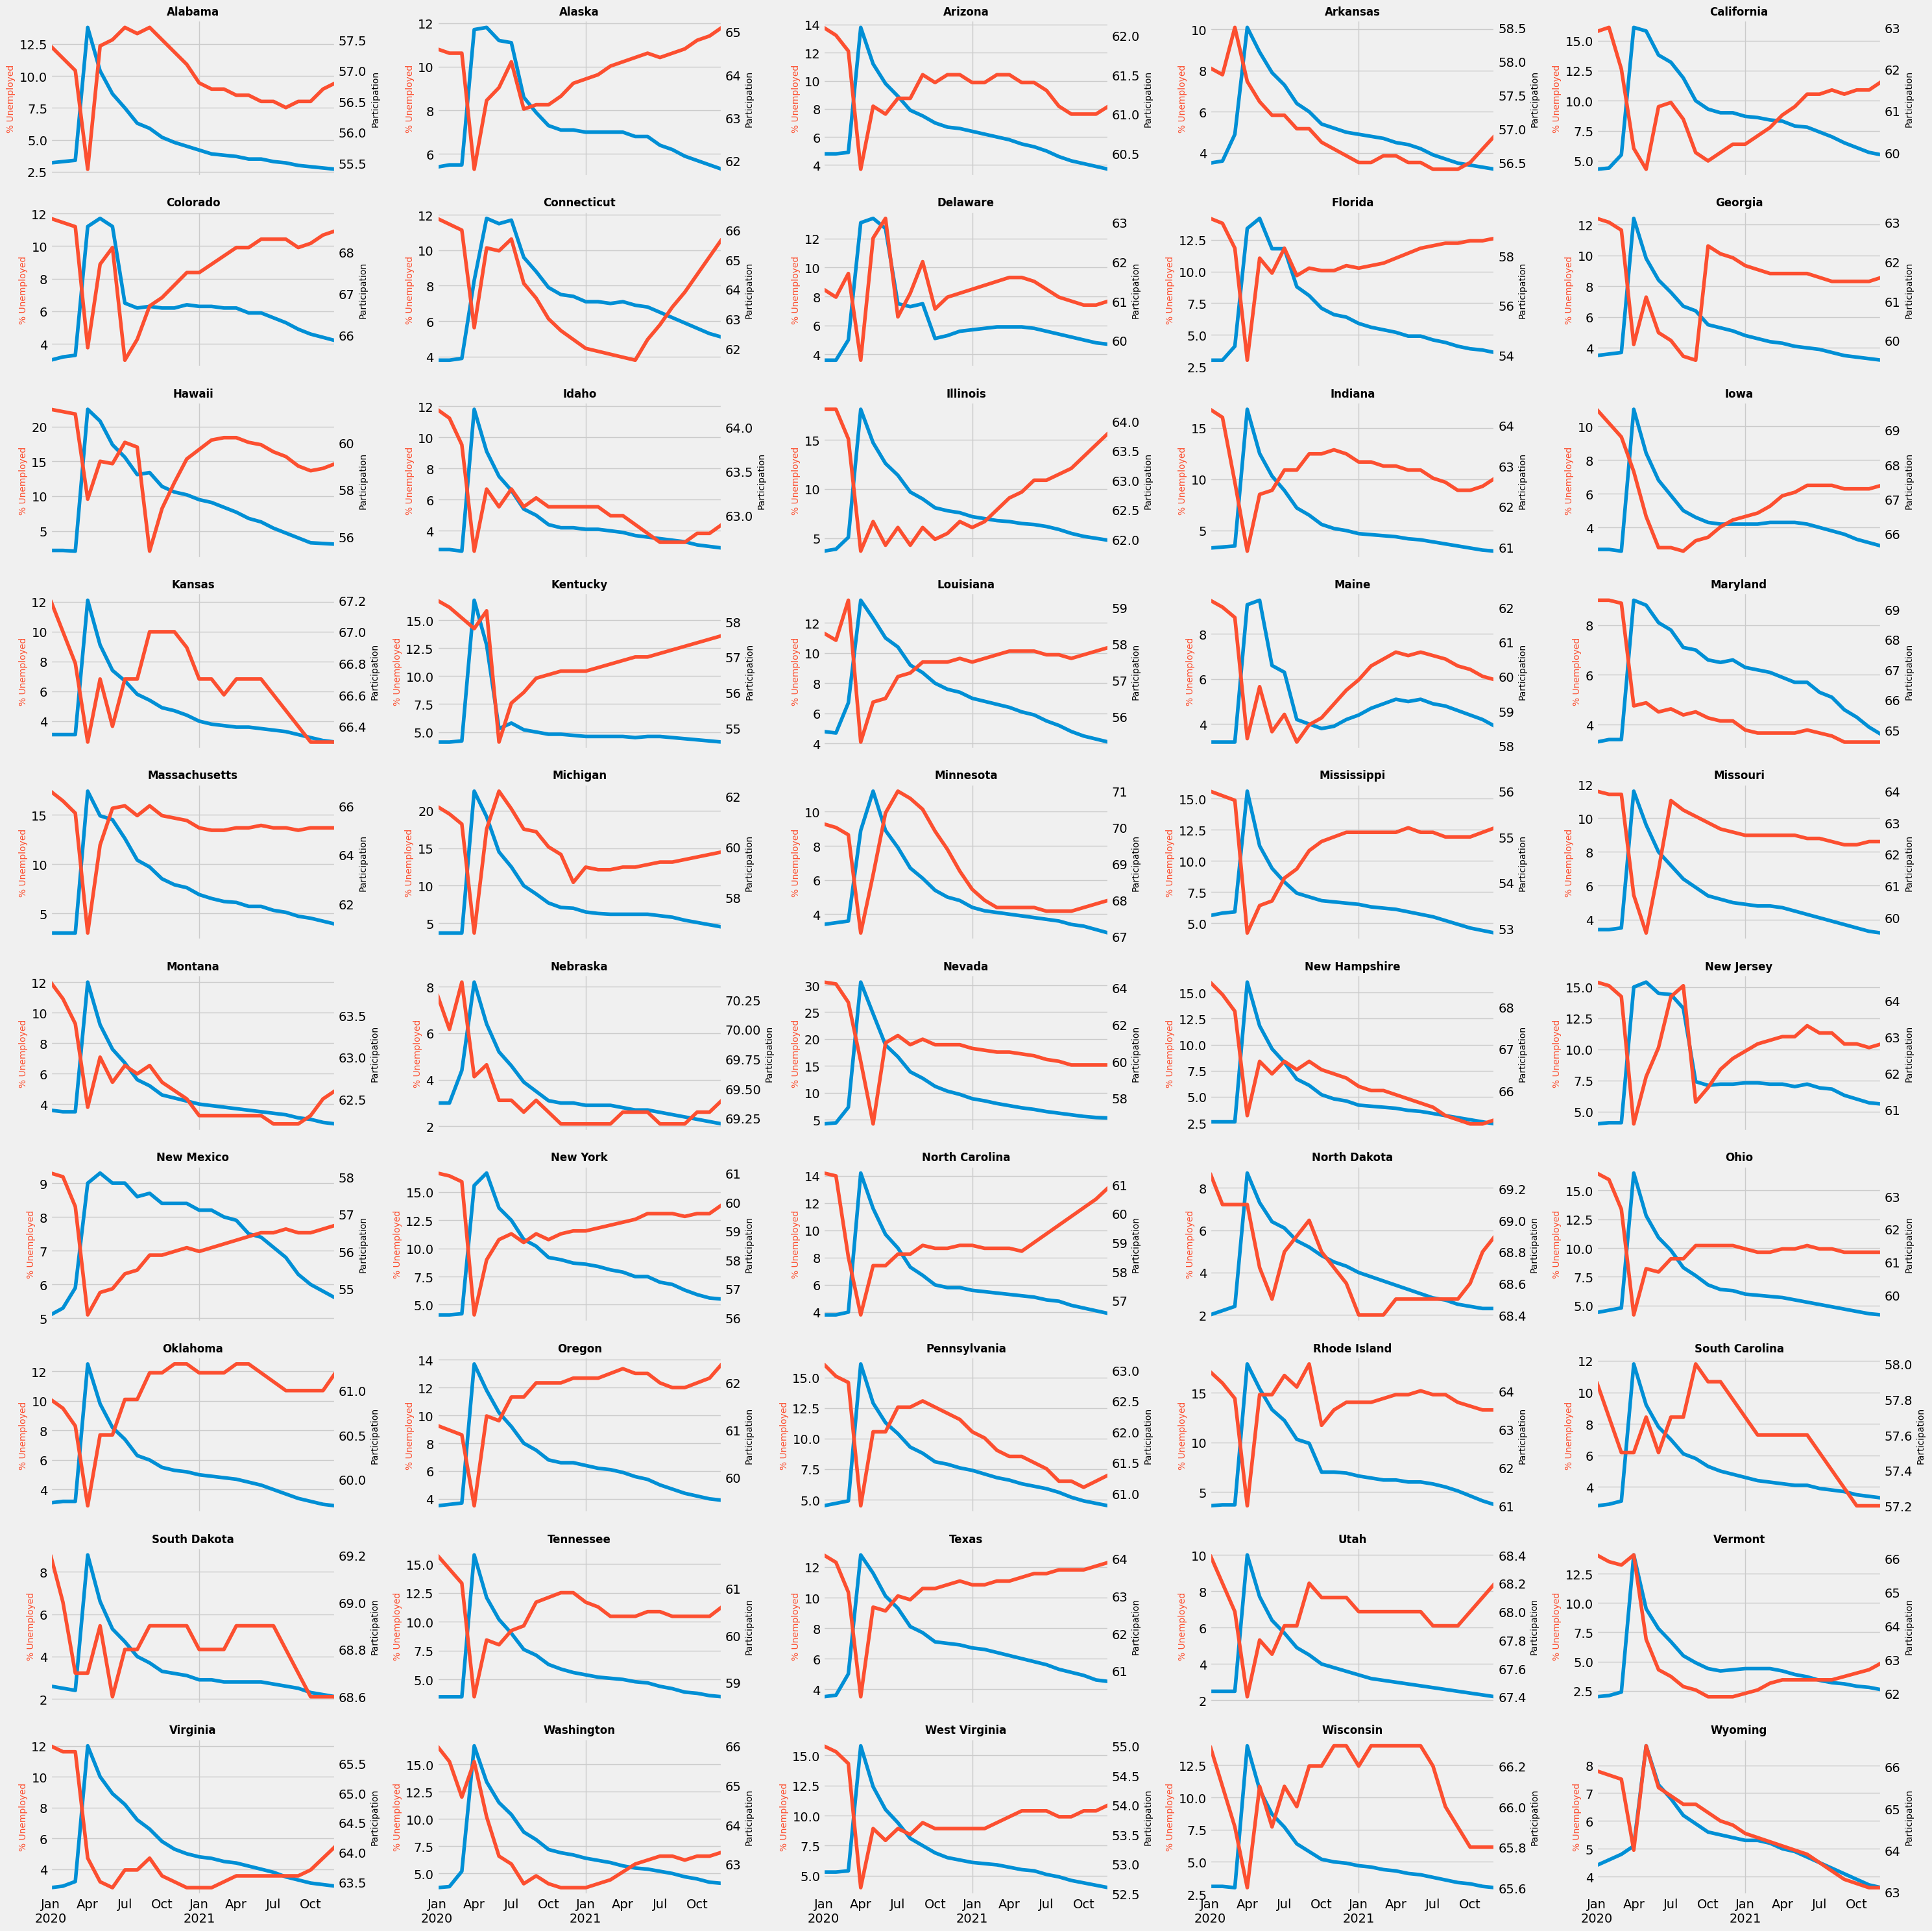

In [12]:
fig, axs = plt.subplots(10,5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in sorted(unemp_results.columns):
    if state == 'DC':
        continue
    ax2 = axs[i].twinx()
    unemp_results.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i])
    part_results.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state, fontsize=12, fontweight='bold')
    axs[i].set_ylabel('% Unemployed', fontsize=10, color=color_pal[1])
    ax2.set_ylabel('Participation', fontsize=10)
    i += 1
plt.tight_layout()
plt.show()

# Read census data for state populations

In [13]:
fred.search('resident population state')

id realtime_start realtime_end  \
series id                                                        
POPTHM                      POPTHM     2025-03-04   2025-03-04   
B230RC0A052NBEA    B230RC0A052NBEA     2025-03-04   2025-03-04   
B230RC0Q173SBEA    B230RC0Q173SBEA     2025-03-04   2025-03-04   
CNP16OV                    CNP16OV     2025-03-04   2025-03-04   
POPTOTUSA647NWDB  POPTOTUSA647NWDB     2025-03-04   2025-03-04   
...                            ...            ...          ...   
PCRGMP36980            PCRGMP36980     2025-03-04   2025-03-04   
PCRGMP36140            PCRGMP36140     2025-03-04   2025-03-04   
PCRGMP14100            PCRGMP14100     2025-03-04   2025-03-04   
GLAKPCEPCDURG        GLAKPCEPCDURG     2025-03-04   2025-03-04   
FWSTPCEPCFUR          FWSTPCEPCFUR     2025-03-04   2025-03-04   

                                                              title  \
series id                                                             
POPTHM                                                   Population   
B230RC0A052NBEA                                          Population   
B230RC0Q173SBEA                                          Population   
CNP16OV                                            Population Level   
POPTOTUSA647NWDB                Population, Total for United States   
...                                                             ...   
PCRGMP36980       Total Per Capita Real Gross Domestic Product f...   
PCRGMP36140       Total Per Capita Real Gross Domestic Product f...   
PCRGMP14100       Total Per Capita Real Gross Domestic Product f...   
GLAKPCEPCDURG     Per Capita Personal Consumption Expenditures: ...   
FWSTPCEPCFUR      Per Capita Personal Consumption Expenditures: ...   

                 observation_start observation_end  frequency frequency_short  \
series id                                                                       
POPTHM                  1959-01-01      2025-01-01    Monthly               M   
B230RC0A052NBEA         1929-01-01      2024-01-01     Annual               A   
B230RC0Q173SBEA         1947-01-01      2024-10-01  Quarterly               Q   
CNP16OV                 1948-01-01      2025-01-01    Monthly               M   
POPTOTUSA647NWDB        1960-01-01      2023-01-01     Annual               A   
...                            ...             ...        ...             ...   
PCRGMP36980             2001-01-01      2017-01-01     Annual               A   
PCRGMP36140             2001-01-01      2017-01-01     Annual               A   
PCRGMP14100             2001-01-01      2017-01-01     Annual               A   
GLAKPCEPCDURG           1997-01-01      2023-01-01     Annual               A   
FWSTPCEPCFUR            1997-01-01      2023-01-01     Annual               A   

                                 units        units_short  \
series id                                                   
POPTHM                       Thousands             Thous.   
B230RC0A052NBEA              Thousands             Thous.   
B230RC0Q173SBEA              Thousands             Thous.   
CNP16OV           Thousands of Persons  Thous. of Persons   
POPTOTUSA647NWDB               Persons            Persons   
...                                ...                ...   
PCRGMP36980       Chained 2009 Dollars        Chn. 2009 $   
PCRGMP36140       Chained 2009 Dollars        Chn. 2009 $   
PCRGMP14100       Chained 2009 Dollars        Chn. 2009 $   
GLAKPCEPCDURG                  Dollars                  $   
FWSTPCEPCFUR                   Dollars                  $   

                      seasonal_adjustment seasonal_adjustment_short  \
series id                                                             
POPTHM            Not Seasonally Adjusted                       NSA   
B230RC0A052NBEA   Not Seasonally Adjusted                       NSA   
B230RC0Q173SBEA   Not Seasonally Adjusted                       NSA   
CNP16OV           Not Seasonally Adjusted     

In [15]:
pop_df_raw = fred.search('resident population state', filter=('frequency', 'Annual'), order_by='popularity', limit=2000)
pop_df = pop_df_raw.query('units == "Thousands of Persons"')
pop_df = pop_df.loc[pop_df['title'].str.contains('Resident Population in')]
pop_df = pop_df.loc[pop_df['id'].str.endswith('POP')]
pop_df = pop_df.loc[pop_df['id'].str.len() == 5]
pop_df = pop_df.loc[~pop_df['title'].str.contains('Federal Reserve District')]
pop_id_to_state = pop_df['title'].str.replace('Resident Population in ', '').to_dict()

In [29]:
all_results = []

for myid in pop_df.index:
    results = fred.get_series(series_id=myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

pop_results = pd.concat(all_results, axis=1)
pop_results.columns = [pop_id_to_state[c] for c in pop_results.columns]
pop_results.rename(columns={'the District of Columbia':'DC'}, inplace=True)
pop_results_in_million = pop_results / 1000

# null-check
# unemp_results.isna().sum(axis=1).plot()

In [38]:
fig = px.line(pop_results,
        labels={
                "variable": "State",
                "index": "Year",
                "value": "Population in thousands"
            })
fig.show()

# Plot Unemployment and Participation vs. State Population

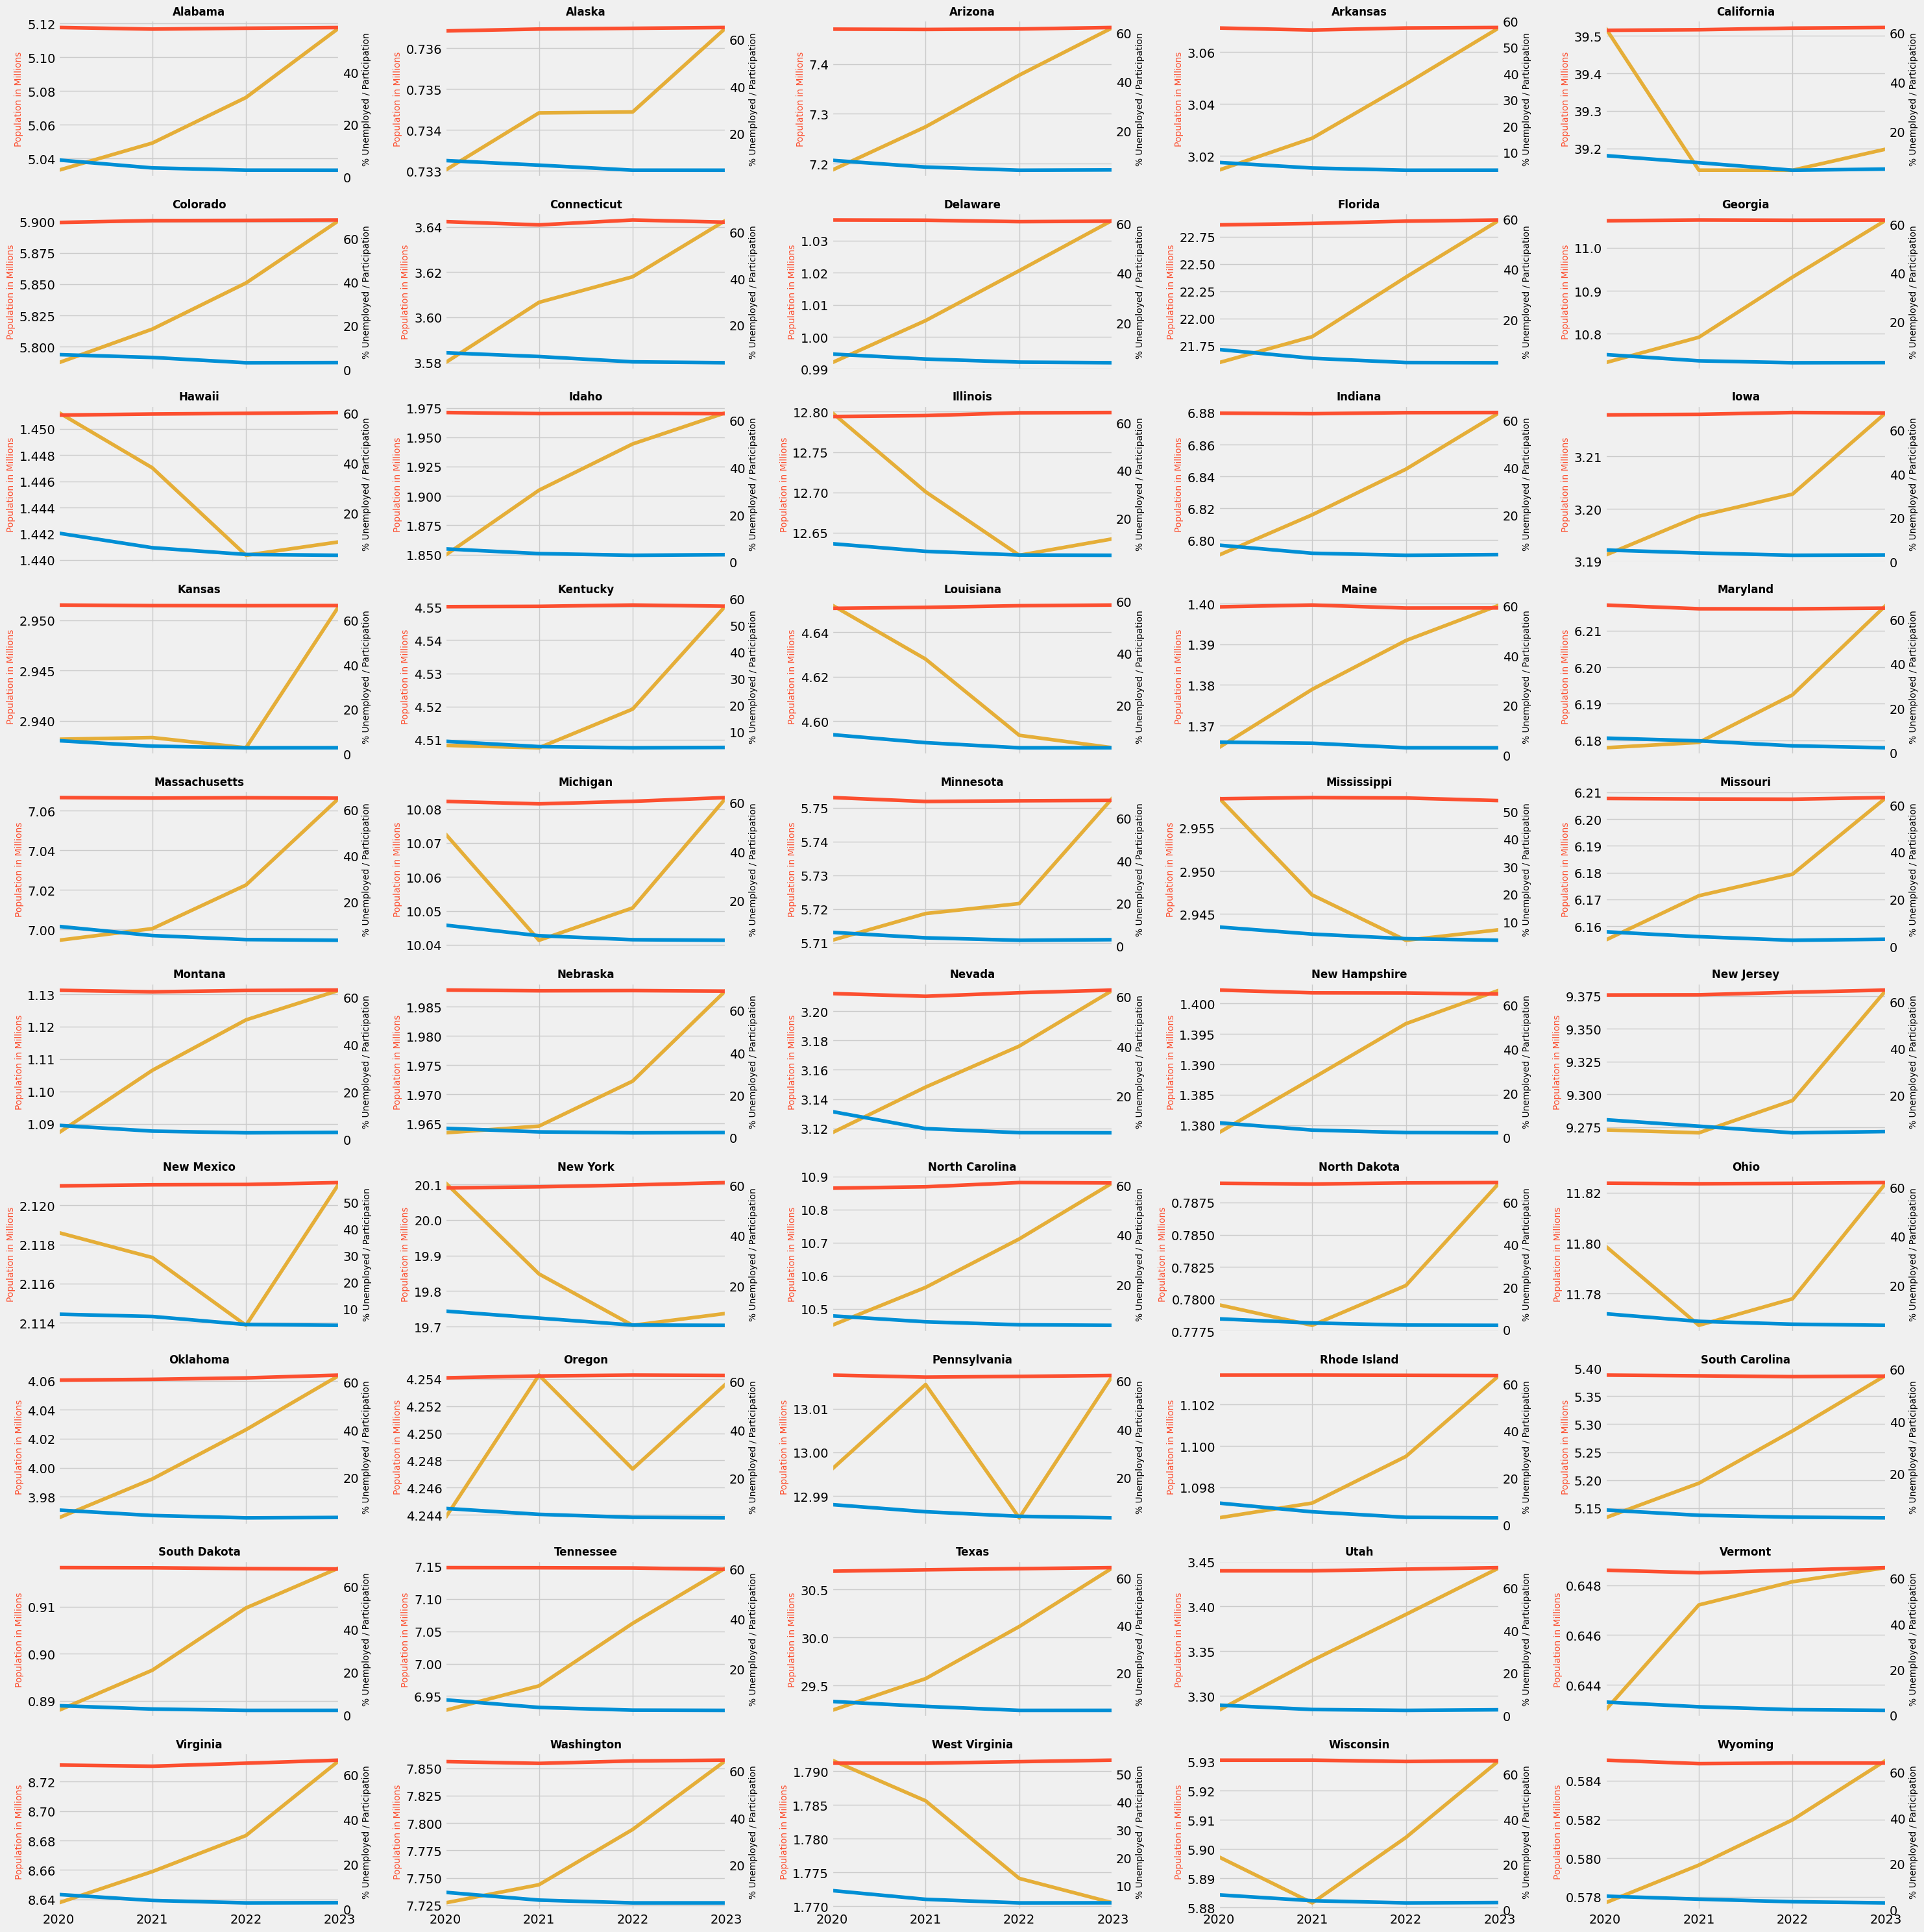

In [61]:
unemp_results_yearly = unemp_results.resample('YE').mean()
part_results_yearly = part_results.resample('YE').mean()

fig, axs = plt.subplots(10,5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in sorted(unemp_results.columns):
    if state == 'DC':
        continue
    ax2 = axs[i].twinx()
    pop_results_in_million.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=axs[i], color=color_pal[2])
    unemp_results_yearly.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=ax2)
    part_results_yearly.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=ax2, color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state, fontsize=12, fontweight='bold')
    axs[i].set_ylabel('Population in Millions', fontsize=10, color=color_pal[1])
    ax2.set_ylabel('% Unemployed / Participation', fontsize=10)
    i += 1
plt.tight_layout()
plt.show()

In [62]:
real_gdp = fred.get_series(series_id='GDPC1')


In [ ]:
real_gdp